# First implementation of ISA on the ScCLEVR dataset

Here I load the first adapted invariant slot attention network trained on the scientific CLEVR (ScCLEVR) dataset.

How I've prodeeced:
- wrote a `data_scclevr.py` file where scclevr data is generated from the scclevr git repo and adjusted to fit our needs.
- wrote a `train-scclevr.py` file where the training happens using the scclevr dataset

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu'

In [3]:
cID_prev = 'isa-alpha3_scclevr'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [4]:
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [5]:
m = InvariantSlotAttention(**hps)

In [6]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  tot  min:  0.06570227444171906  at  4700
loss  bce  min:  0.01626218855381012  at  4273
loss  mse  min:  0.01559397578239441  at  4993


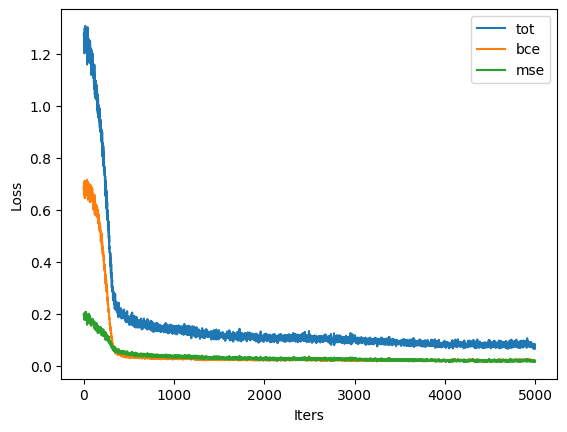

In [7]:
for k,v in losses.items():
    plt.plot(v,label=k)
    print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
lastIter = 5000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

m.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 5000


<All keys matched successfully>

Lovely, that looks good. 

Now load **scclevr data**:

In [9]:
from data_scclevr import makeRings 

In [10]:
bs = 1000
kwargs = cd['data']


In [11]:
X, mask, _, Y = makeRings(N_img=bs, N_obj=kwargs["N_clusters"], device=device)

## Evalute the model

In [12]:
from train import hungarian_matching
import torch.nn.functional as F

k_slots=3
max_n_rings=2
resolution=(32,32)

In [13]:
alpha = cd['opt']['alpha']

In [14]:
with torch.no_grad():

    torch.manual_seed(torch_seed)
    queries, att, Y_pred = m(X)
         
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 

    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)

    # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
    indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean(axis=-1)

    # Calculate the loss
    print(l_bce.shape)
    print(l_mse.shape)
    li = l_bce + alpha*l_mse
    

torch.Size([1000])
torch.Size([1000])


In [15]:
l_kl = F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1)

Investigate KL-divergence

In [16]:
F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').shape

torch.Size([1000, 2, 1024])

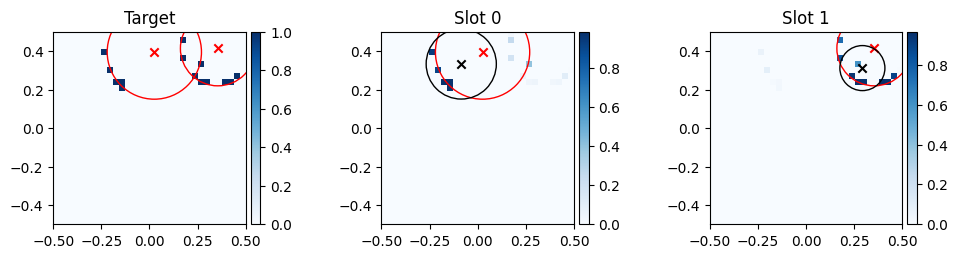

In [19]:
plot_chosen_slots_only(
                  mask[0].sum(axis=0), 
                  slots_sorted[0].reshape(max_n_rings,*resolution),
                  Y_true_sorted[0],
                  Y_pred_sorted[0])

mean first pic tensor(0.0011)
mean second pic tensor(0.0008)
kl div: tensor(0.0019)


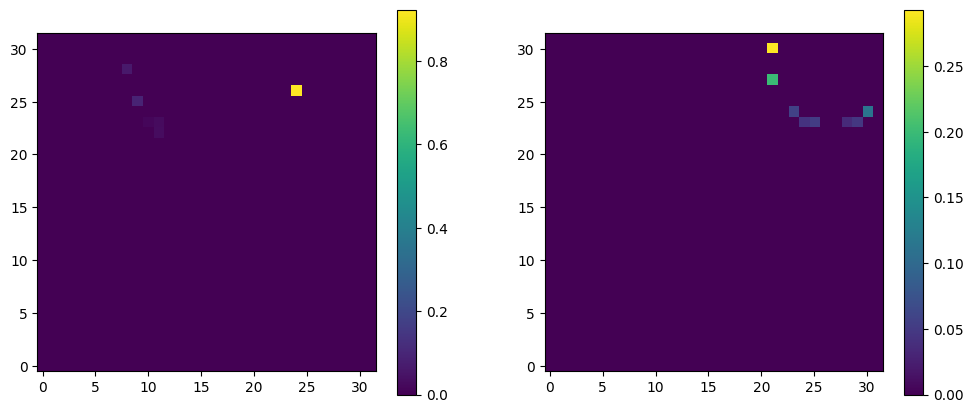

In [20]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1,2,1)
plt.imshow(F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none')[0, 0].reshape(32,32), origin='lower')
plt.colorbar()
fig.add_subplot(1,2,2)
plt.imshow(F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none')[0, 1].reshape(32,32), origin='lower')
plt.colorbar()
print("mean first pic", F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none')[0, 0].mean(axis=-1))
print("mean second pic", F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none')[0, 1].mean(axis=-1))
print("kl div:", l_kl[0])

In [21]:
mi = l_kl < 10e-5 # good events
torch.sum(mi)
mj = l_kl > 10e-3 # bad events
torch.sum(mj)

good_imgs = mask[mi].sum(axis=1)
bad_imgs  = mask[mj].sum(axis=1)

In [22]:
def plot_chosen_slots_only(mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+1,figsize=(3*(n_rings + 2) ,2.5))
   
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[0:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[0]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[1:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    #if figname:
    #    plt.savefig(figname)

    plt.show()
    plt.close()

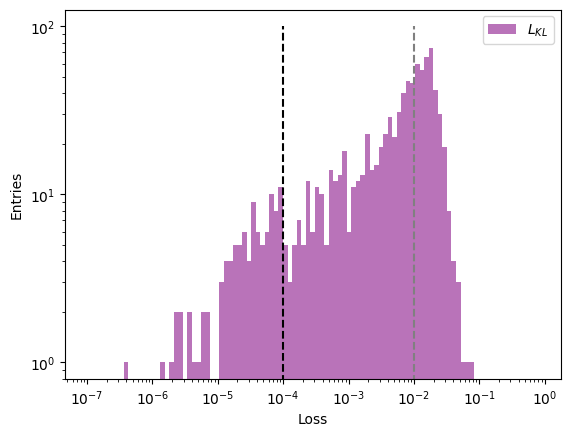

In [23]:
bins = np.array([10e-4,10e-3, 10e-2, 10e-1])
bins= 10**(np.linspace(-7, -0.1, 100))
plt.hist(l_kl, color='purple', label="$L_{KL}$", alpha=0.55, bins=bins)

#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.vlines([10e-5, 10e-3], 0, 100, colors=['black', 'grey'], linestyle="--")

#plt.plot([10e-4]*2,ylim,'k--')
#plt.plot([10e-2]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.show()

In [24]:
X_Nhits = torch.squeeze(torch.sum(X, axis=(-1, -2)), axis=-1)

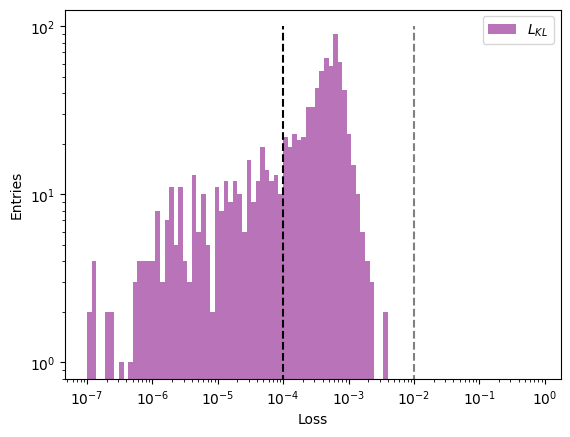

In [26]:

l_kl_new =F.kl_div(torch.log(slots_sorted),rings_sorted,reduction='none').sum(axis=1).mean(axis=-1) / X_Nhits

bins = np.arange(4)[::-1]
bins= 10**(np.linspace(-7, -0.1, 100))
plt.hist(l_kl_new, color='purple', label="$L_{KL}$", alpha=0.55, bins=bins)

#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.vlines([10e-5, 10e-3], 0, 100, colors=['black', 'grey'], linestyle="--")

#plt.plot([10e-4]*2,ylim,'k--')
#plt.plot([10e-2]*2,ylim,'grey',ls='--')

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.show()

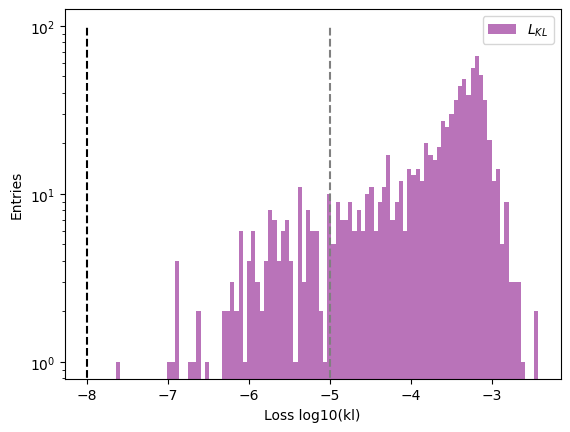

In [27]:
plt.hist(np.log10(l_kl_new), color='purple', label="$L_{KL}$", alpha=0.55, bins=100)

#plt.hist(l_bce.numpy(),100,color='r', label="$L_{BCE}$", alpha=0.55, range=(0, 0.35))
plt.xlabel('Loss log10(kl)')
plt.ylabel('Entries')

ylim = plt.ylim()
plt.vlines([-8, -5], 0, 100, colors=['black', 'grey'], linestyle="--")

plt.legend()
plt.yscale("log")

plt.show()

**Bad exapmles**

In [ ]:
for count, k in enumerate(np.where(l_kl > 10e-3)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

**Good exapmles**

In [ ]:
for count, k in enumerate(np.where(l_kl < 10e-5)[0]):
    iEvt = k
    print("KL: ", l_kl[iEvt])
    plot_chosen_slots_only(
                  mask[iEvt].sum(axis=0), 
                  slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                  Y_true_sorted[iEvt],
                  Y_pred_sorted[iEvt])
    if count>15:
        break

In [ ]:
import evaluation as ev

In [ ]:
plt.style.use('./../standard_style.mlpstyle')

In [ ]:
print("KL-divergence: ", ev.KL_divergence(slots_sorted, rings_sorted))
ev.student_t(Y_pred_sorted, Y_true_sorted)

In [ ]:
np.log10(0.00909169)

In [ ]:
np.log10(0.0070981206)

Why KL-divergence not much worse??
-> not normed on number of hits? (but reduction=mean whoudl be ok? wrong parameter?)

# Conculsion

- must worse than on previous "full" rings
- separation worse, rings x,y,R worse even in well separated images

## what's next? Ideas?

- not sure if the "invariant" part helps at all... ring centers always drawn to the gravity center which is not helpful if rings are cut of. 